In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
random_state = 42

In [2]:
train_df = pd.read_csv('train.csv', index_col='id')

#### Data preprocessing

In [207]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = random_state)

# model = Ridge(alpha = 1)
# model = LinearRegression()
model = RandomForestRegressor(n_estimators = 10)
model.fit(X_train, y_train)

C:\Users\thamnt36\Anaconda3\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


RandomForestRegressor(n_estimators=10)

In [195]:
X_train.shape

(2400710, 107)

In [208]:
y_pred = model.predict(np.asarray(X_val))
rmsle(y_val, y_pred)

1.2186837729940758

In [71]:
from sklearn.linear_model import Lasso
model = Lasso(alpha = 1)
model.fit(X_train, y_train)
y_pred = model.predict(np.asarray(X_val))
rmsle(y_val, y_pred) 

C:\Users\thamnt36\Anaconda3\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


2.5135716990453227

In [7]:
test_df = pd.read_csv('test.csv', index_col='id')
test_df.head()

,date,store_nbr,family,onpromotion
id,,,,
3000888,2017-08-16,1,AUTOMOTIVE,0
3000889,2017-08-16,1,BABY CARE,0
3000890,2017-08-16,1,BEAUTY,2
3000891,2017-08-16,1,BEVERAGES,20
3000892,2017-08-16,1,BOOKS,0


In [9]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
class FeatureEncoder(object):
    """
        Thực hiện:
         - chuyển family, store_nbr -> one-hot
         - chuyển date -> tập one-hot của dayOfWeek & của month
         - normalize onPromotion
    """
    def __init__(self, X_df):
        self.family_encoder = OneHotEncoder().fit(X_df[['family']])
        self.store_nbr_encoder = OneHotEncoder().fit(X_df[['store_nbr']])
        weekday = pd.to_datetime(X_df['date']).dt.dayofweek.values.reshape(-1,1)
        self.week_encoder = OneHotEncoder().fit(weekday)
        month = pd.to_datetime(X_df['date']).dt.month.values.reshape(-1,1)
        self.month_encoder = OneHotEncoder().fit(month)
        self.scaler = StandardScaler().fit(X_df[['onpromotion']])

    def date2feature(self, date_col):
        weekday = pd.to_datetime(date_col).dt.dayofweek.values.reshape(-1,1)
        weekday_feature = self.week_encoder.transform(weekday).todense()
        month = pd.to_datetime(date_col).dt.month.values.reshape(-1,1)
        month_feature = self.month_encoder.transform(month).todense()
        return np.hstack([weekday_feature, month_feature])

    def preprocess(self, df):
        family_features = self.family_encoder.transform(df[['family']]).todense()
        store_nbr_features = self.store_nbr_encoder.transform(df[['store_nbr']]).todense()
        date_features = self.date2feature(df['date'])
        onProm_feature = self.scaler.transform(df[['onpromotion']])
        X1 = np.hstack([family_features, store_nbr_features])
        X2 = np.hstack([date_features, onProm_feature])
        print(X1.shape, X2.shape)
        X = np.hstack([X1, X2])
        return X
encoder = FeatureEncoder(train_df)
X_test = encoder.preprocess(test_df)
print(X_test.shape)

(28512, 87) (28512, 20)
(28512, 107)


In [110]:
y_pred = model.predict(X_test)
y_pred = np.where(y_pred > 0, y_pred, 0)
submit = pd.DataFrame(np.hstack([test_df.index.values.reshape(-1, 1), y_pred.reshape(-1, 1)]), columns = ['id', 'sales'])
submit.id = submit.id.astype(np.int32)
submit.to_csv('submit.csv', index=False)

C:\Users\thamnt36\Anaconda3\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


array([-166.421875, -170.796875, -133.125   , ..., 1162.953125,
        188.796875,   38.953125])

In [140]:
submit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28512 entries, 0 to 28511
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      28512 non-null  int32  
 1   sales   28512 non-null  float64
dtypes: float64(1), int32(1)
memory usage: 334.2 KB


In [133]:
np.hstack([test_df.index.values.reshape(-1, 1).astype(np.int32), y_pred.reshape(-1, 1)]).shape

(28512, 2)

### EDA

#### Tìm hiểu file holiday-events

**Findings:**

(1) Holiday: Xét tương quan với số lượng transaction:
    
    + Holiday type: so sánh phân phối số lượng transaction
    + Holiday locale
    + Holiday locale_name
    
(2) Transaction: Xét thay đổi qua thời gian
    
    + Ngày trong tuần: so sánh phân phối số lượng transaction
    + Ngày trong tháng: (để xem 2 đợt phát lương có ảnh hưởng không)
    + Tháng trong năm
    + Tìm tính mùa vụ trong dữ liệu
    + Xu hướng tăng của năm

(3) Oil: 
    
    + biến động giá dầu qua thời gian
    
(4) sale of each product family, oil price: 
    
    + Thay đổi sale của từng mặt hàng qua thời gian
    + Tương quan của giá dầu với sale của các mặt hàng
    
(5) Cửa hàng: so sánh phân phối số lượng transaction, theo các trường sau (để giảm bớt mức đa dạng của thuộc tính)
    
    + type
    + cluster
    + city
    + state

(6) Tương quan giữa các giá trị lag của oil với sale

(7) Tìm hiểu tương quan các chỉ số kinh tế tới sale

### Holiday

In [3]:
holiday_df = pd.read_csv("holidays_events.csv")
train_df = pd.read_csv("train.csv")
transaction_df = pd.read_csv("transactions.csv")

In [4]:
holiday_df = holiday_df.loc[holiday_df['transferred'] == False, :]
holiday_df = holiday_df.drop_duplicates(subset='date')
holiday_df.shape

(300, 6)

In [5]:
def transform_date(date):
    # change from "MM/DD/YYYY" -> "YYYY-MM-DD"
    tmp = date.split('/')
    month, day, year = tmp[0], tmp[1], tmp[2]
    if (len(month) == 1): 
        month = '0' + month
    if (len(day) == 1): 
        day = '0' + day
    return "-".join([year, month, day])
holiday_df['date'] = holiday_df['date'].apply(transform_date)

In [6]:
th_df = transaction_df.merge(holiday_df, how='left', left_on = 'date', right_on = 'date')
th_df = th_df.fillna("None")
th_df.head(3)

,date,store_nbr,transactions,type,locale,locale_name,description,transferred
0,2013-01-01,25,770,Holiday,National,Ecuador,Primer dia del ano,False
1,2013-01-02,1,2111,None,None,None,None,None
2,2013-01-02,2,2358,None,None,None,None,None


##### a. Holiday type

<AxesSubplot:xlabel='type'>

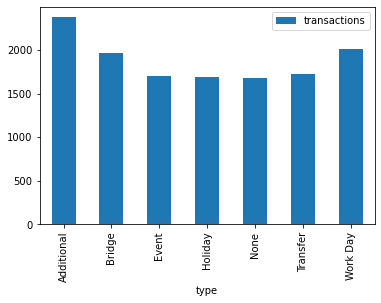

In [19]:
# Biểu đồ cột
x = pd.DataFrame(th_df.groupby(['type'])['transactions'].mean())
x.plot.bar()

In [39]:
merged_df = train_df.merge(holiday_df, how='left', left_on = 'date', right_on = 'date')
merged_df.loc[:, ['type']] = merged_df['type'].fillna("Not Holiday")
merged_df.loc[:, ['locale_name']] = merged_df['locale_name'].fillna("None")
merged_df.head(3)

,id,date,store_nbr,family,sales,onpromotion,type,locale,locale_name,description,transferred
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Holiday,National,Ecuador,Primer dia del ano,False
1,1,2013-01-01,1,BABY CARE,0.0,0,Holiday,National,Ecuador,Primer dia del ano,False
2,2,2013-01-01,1,BEAUTY,0.0,0,Holiday,National,Ecuador,Primer dia del ano,False


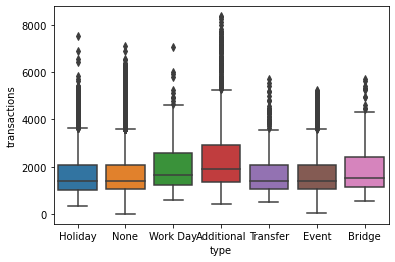

In [44]:
import seaborn as sns
sns.boxplot(x = 'type', y = 'transactions', data = th_df)
plt.show()

In [27]:
store_df = pd.read_csv('stores.csv')
store_df['store_nbr']

0      1
1      2
2      3
3      4
4      5
5      6
6      7
7      8
8      9
9     10
10    11
11    12
12    13
13    14
14    15
15    16
16    17
17    18
18    19
19    20
20    21
21    22
22    23
23    24
24    25
25    26
26    27
27    28
28    29
29    30
30    31
31    32
32    33
33    34
34    35
35    36
36    37
37    38
38    39
39    40
40    41
41    42
42    43
43    44
44    45
45    46
46    47
47    48
48    49
49    50
50    51
51    52
52    53
53    54
Name: store_nbr, dtype: int64

In [52]:
transaction_df.head(3)

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358


In [53]:
tmp = transaction_df.groupby('store_nbr')['transactions'].mean()
store_df2 = store_df.merge(tmp, how='left', left_on = 'store_nbr', right_on = 'store_nbr')

In [40]:
oil_df = pd.read_csv('oil.csv')
oil_df.head(10)

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20
5,2013-01-08,93.21
6,2013-01-09,93.08
7,2013-01-10,93.81
8,2013-01-11,93.60
9,2013-01-14,94.27


### Transaction

In [65]:
transaction_df['date'] = pd.to_datetime(transaction_df['date'], infer_datetime_format=True)

In [78]:
transaction_df['weekday'] = transaction_df['date'].dt.dayofweek.values
transaction_df['month'] = transaction_df['date'].dt.month.values
transaction_df['year'] = transaction_df['date'].dt.year.values

##### a. Ngày trong tuần

<AxesSubplot:xlabel='weekday'>

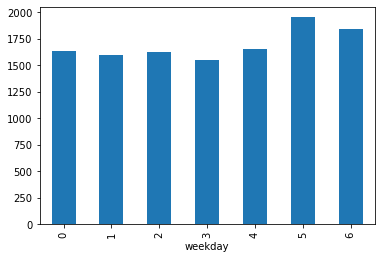

In [75]:
transaction_df.groupby('weekday')['transactions'].mean().plot.bar()

##### Ngày trong tháng

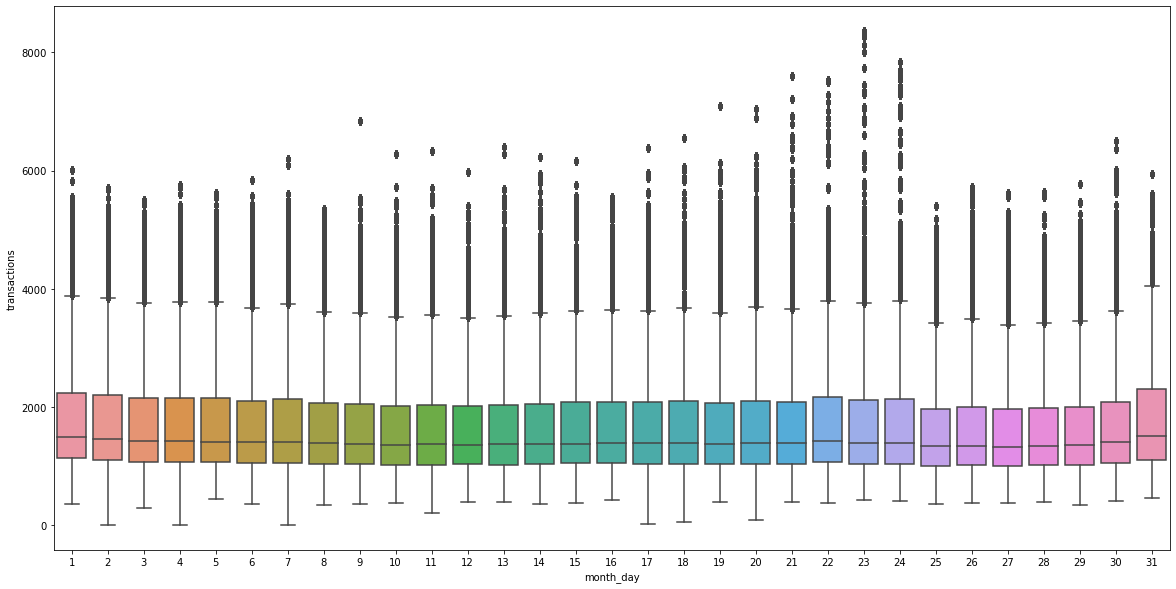

In [24]:
plt.figure(figsize = (20, 10))
sns.boxplot(x = 'month_day', y = 'transactions', data = mhsot_df)
plt.show()

##### b. Tháng trong năm

<AxesSubplot:xlabel='month'>

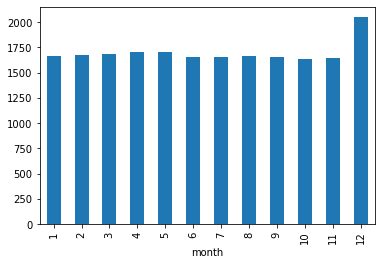

In [76]:
transaction_df.groupby('month')['transactions'].mean().plot.bar()

In [83]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3000888 entries, 0 to 3000887
Data columns (total 5 columns):
 #   Column       Dtype  
---  ------       -----  
 0   date         object 
 1   store_nbr    int64  
 2   family       object 
 3   sales        float64
 4   onpromotion  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 137.4+ MB


In [84]:
train_df['date'] = pd.to_datetime(train_df['date'], infer_datetime_format=True)
train_df['year'] = train_df['date'].dt.year.values

##### c. Năm

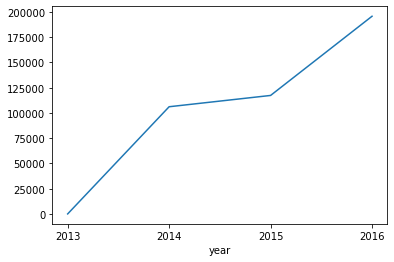

In [106]:
product_df = train_df.loc[(train_df['family'] == 'PLAYERS AND ELECTRONICS') & (train_df['year'] < 2017), :]
product_df.groupby('year')['sales'].sum().plot()
plt.xticks(range(2013, 2017))
plt.show()

In [107]:
train_df.loc[train_df['family'] == 'POULTRY', ['year', 'sales']].corr()

,year,sales
year,1.000000,0.124221
sales,0.124221,1.000000


### Cửa hàng

##### a. locale_name

<AxesSubplot:xlabel='locale_name'>

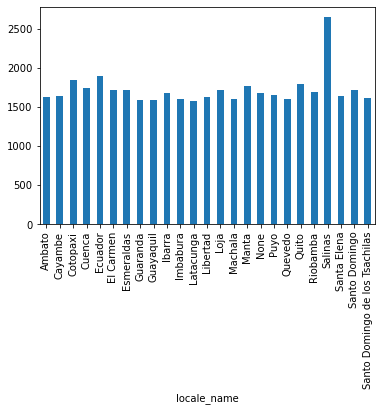

In [110]:
th_df.groupby('locale_name')['transactions'].mean().plot.bar()

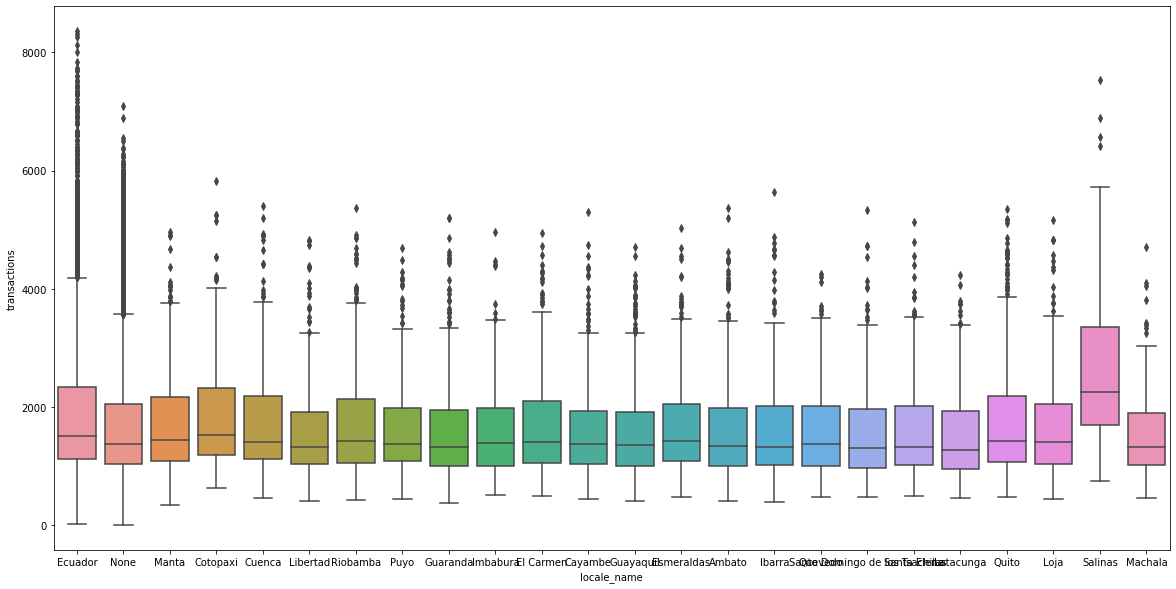

In [58]:
plt.figure(figsize = (20, 10))
sns.boxplot(x = 'locale_name', y = 'transactions', data = ths_df)
plt.show()

##### store_nbr

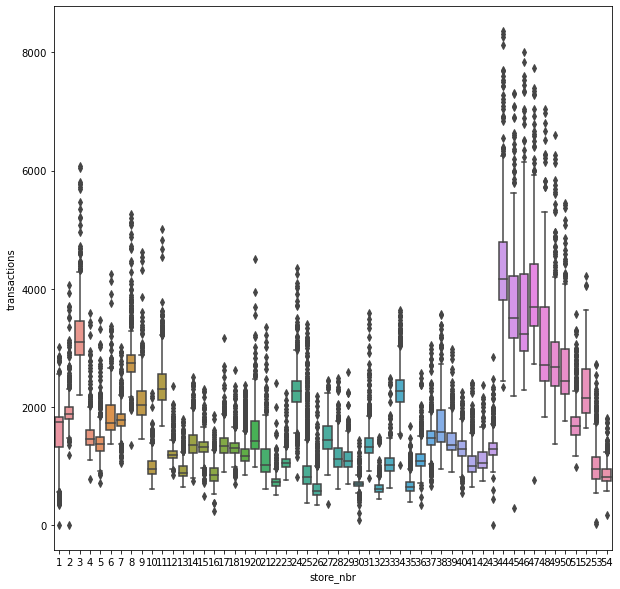

In [46]:
import seaborn as sns
plt.figure(figsize = (10, 10))
sns.boxplot(x = 'store_nbr', y = 'transactions', data = th_df)
plt.show()

In [61]:
store_df = pd.read_csv('stores.csv')
oil_df = pd.read_csv('oil.csv')

In [48]:
ths_df = th_df.merge(store_df, how = 'left', left_on = 'store_nbr', right_on = 'store_nbr')

##### city

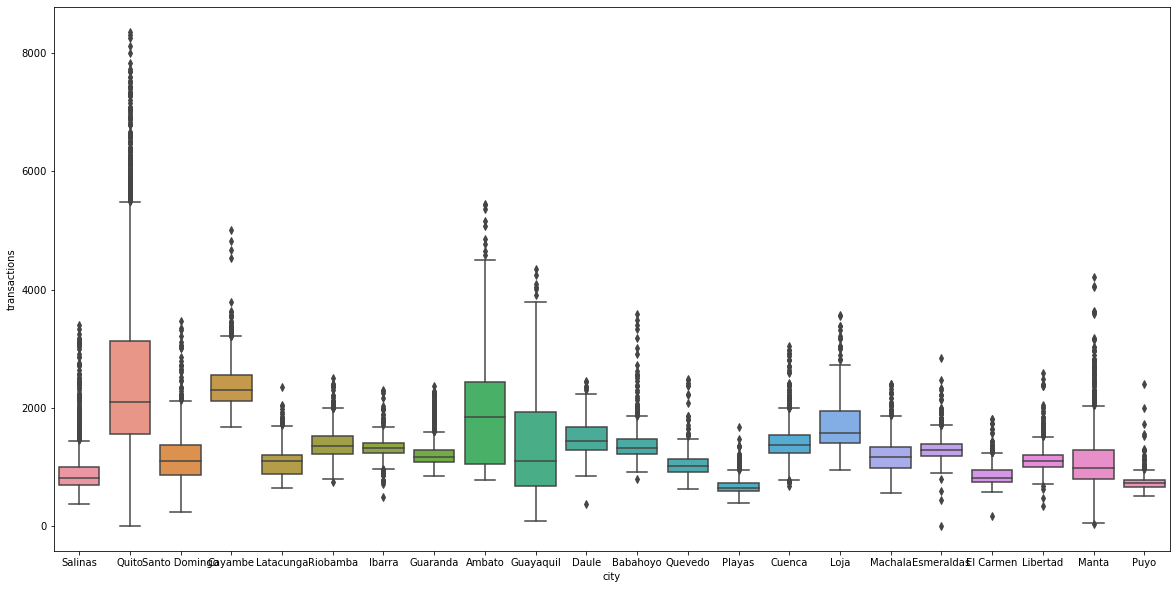

In [53]:
import seaborn as sns
plt.figure(figsize = (20, 10))
sns.boxplot(x = 'city', y = 'transactions', data = ths_df)
plt.show()

##### State

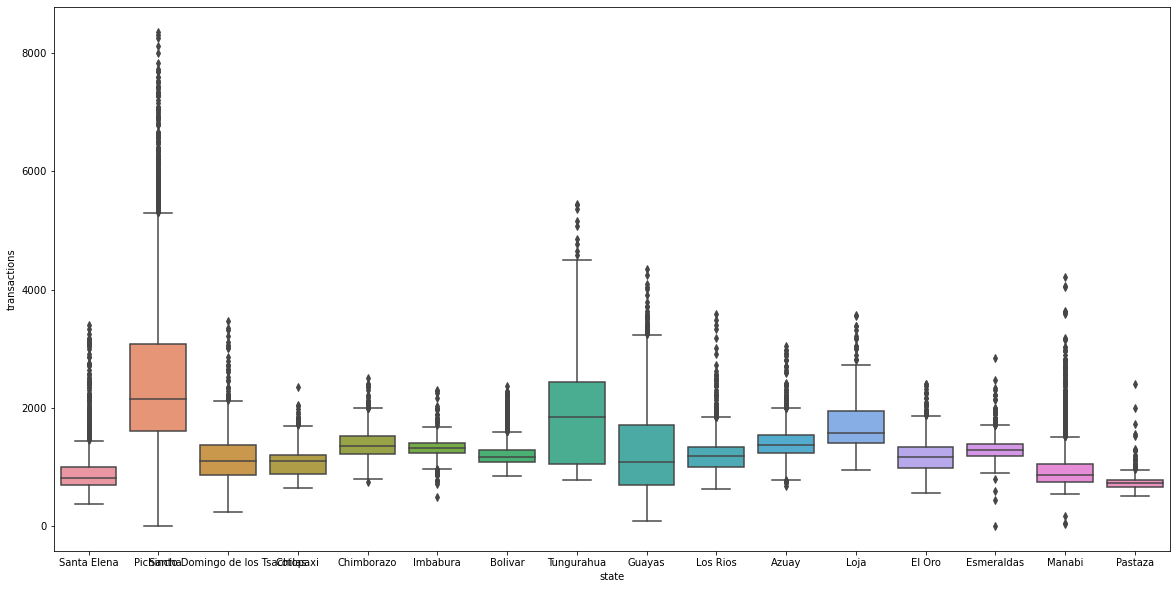

In [54]:
plt.figure(figsize = (20, 10))
sns.boxplot(x = 'state', y = 'transactions', data = ths_df)
plt.show()

##### store_type

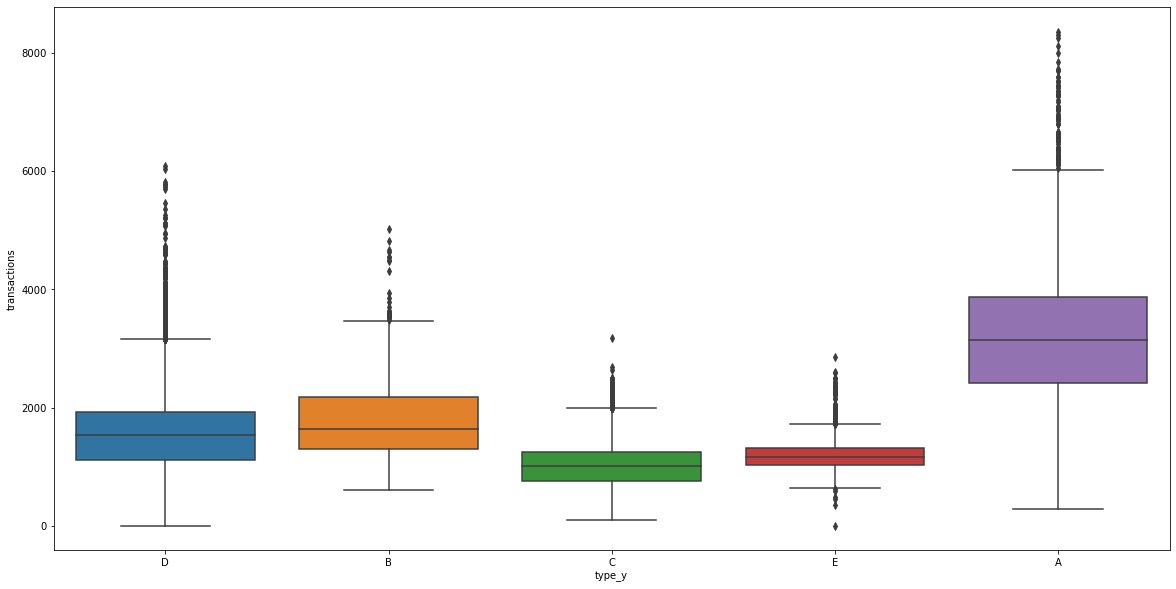

In [56]:
plt.figure(figsize = (20, 10))
sns.boxplot(x = 'type_y', y = 'transactions', data = ths_df)
plt.show()

In [3]:
def get_oil_lag(oil_df):
    lag_oil_df = oil_df.copy()
    lag_oil_df['month'] = pd.to_datetime(oil_df['date']).dt.month.values
    lag_oil_df['year'] = pd.to_datetime(oil_df['date']).dt.year.values
    mean_oil = lag_oil_df.groupby(['year', 'month'])['dcoilwtico'].mean().reset_index()
    mean_oil.rename(columns = {"dcoilwtico" : 'month_mean'}, inplace = True)
    fillna_vals = pd.Series([92.12,93.13, 94.14])
    mean = pd.concat([fillna_vals, mean_oil['month_mean']])
    mean_oil['last1month'] = mean.shift(1)[3:]
    mean_oil['last2month'] = mean.shift(2)[3:]
    mean_oil['last3month'] = mean.shift(3)[3:]
    lag_oil_df = lag_oil_df.merge(mean_oil, how = 'left', right_on = ['year', 'month'], left_on = ['year', 'month'])
    lag_oil_df.drop('month', inplace = True, axis = 1)
    lag_oil_df.drop('year', inplace = True, axis = 1)
    # handle missing value in oil dataframe
    lag_oil_df['dcoilwtico'] = fill_nan(lag_oil_df['dcoilwtico'])
    return lag_oil_df

In [4]:
def fill_nan(series):
    n = len(series)
    arr = series.values
    for i in range(n):
        if (np.isnan(arr[i])):
            if (i - 1 < 0):
                print(i)
                v = arr[i + 1] # chưa chặt lắm
            else:
                v = arr[i - 1]
            arr[i] = v
    return arr

In [2]:
train_df = pd.read_csv('train.csv', index_col='id')
holiday_df = pd.read_csv("holidays_events.csv")
transaction_df = pd.read_csv("transactions.csv")
store_df = pd.read_csv('stores.csv')
oil_df = pd.read_csv('oil.csv')
test_df = pd.read_csv('test.csv', index_col='id')

In [5]:
def transform_date(date):
    # change from "MM/DD/YYYY" -> "YYYY-MM-DD"
    tmp = date.split('/')
    month, day, year = tmp[0], tmp[1], tmp[2]
    if (len(month) == 1): 
        month = '0' + month
    if (len(day) == 1): 
        day = '0' + day
    return "-".join([year, month, day])
holiday_df['date'] = holiday_df['date'].apply(transform_date)

In [6]:
# main dataframe (train_df or test_df) merged with holiday_df
mh_df = train_df.merge(holiday_df, how='left', left_on = 'date', right_on = 'date')
mh_df = mh_df.fillna("None")
mhs_df = mh_df.merge(store_df, how='left', left_on = 'store_nbr', right_on = 'store_nbr')
mhso_df = mhs_df.merge(oil_df, how='left', left_on = 'date', right_on = 'date')
mhso_df['dcoilwtico'] = fill_nan(mhso_df['dcoilwtico'])

0


In [7]:
mhso_df.head(4)

,date,store_nbr,family,sales,onpromotion,type_x,locale,locale_name,description,transferred,city,state,type_y,cluster,dcoilwtico
0,2013-01-01,1,AUTOMOTIVE,0.0,0,Holiday,National,Ecuador,Primer dia del ano,False,Quito,Pichincha,D,13,NaN
1,2013-01-01,1,BABY CARE,0.0,0,Holiday,National,Ecuador,Primer dia del ano,False,Quito,Pichincha,D,13,NaN
2,2013-01-01,1,BEAUTY,0.0,0,Holiday,National,Ecuador,Primer dia del ano,False,Quito,Pichincha,D,13,NaN
3,2013-01-01,1,BEVERAGES,0.0,0,Holiday,National,Ecuador,Primer dia del ano,False,Quito,Pichincha,D,13,NaN


In [85]:
mhso_df.head(1)

,date,store_nbr,family,sales,onpromotion,type_x,locale,locale_name,description,transferred,city,state,type_y,cluster,dcoilwtico,month
0,2013-01-01,1,AUTOMOTIVE,0.0,0,Holiday,National,Ecuador,Primer dia del ano,False,Quito,Pichincha,D,13,NaN,1


### Product type 

##### Biến đổi sales của từng type theo thời gian

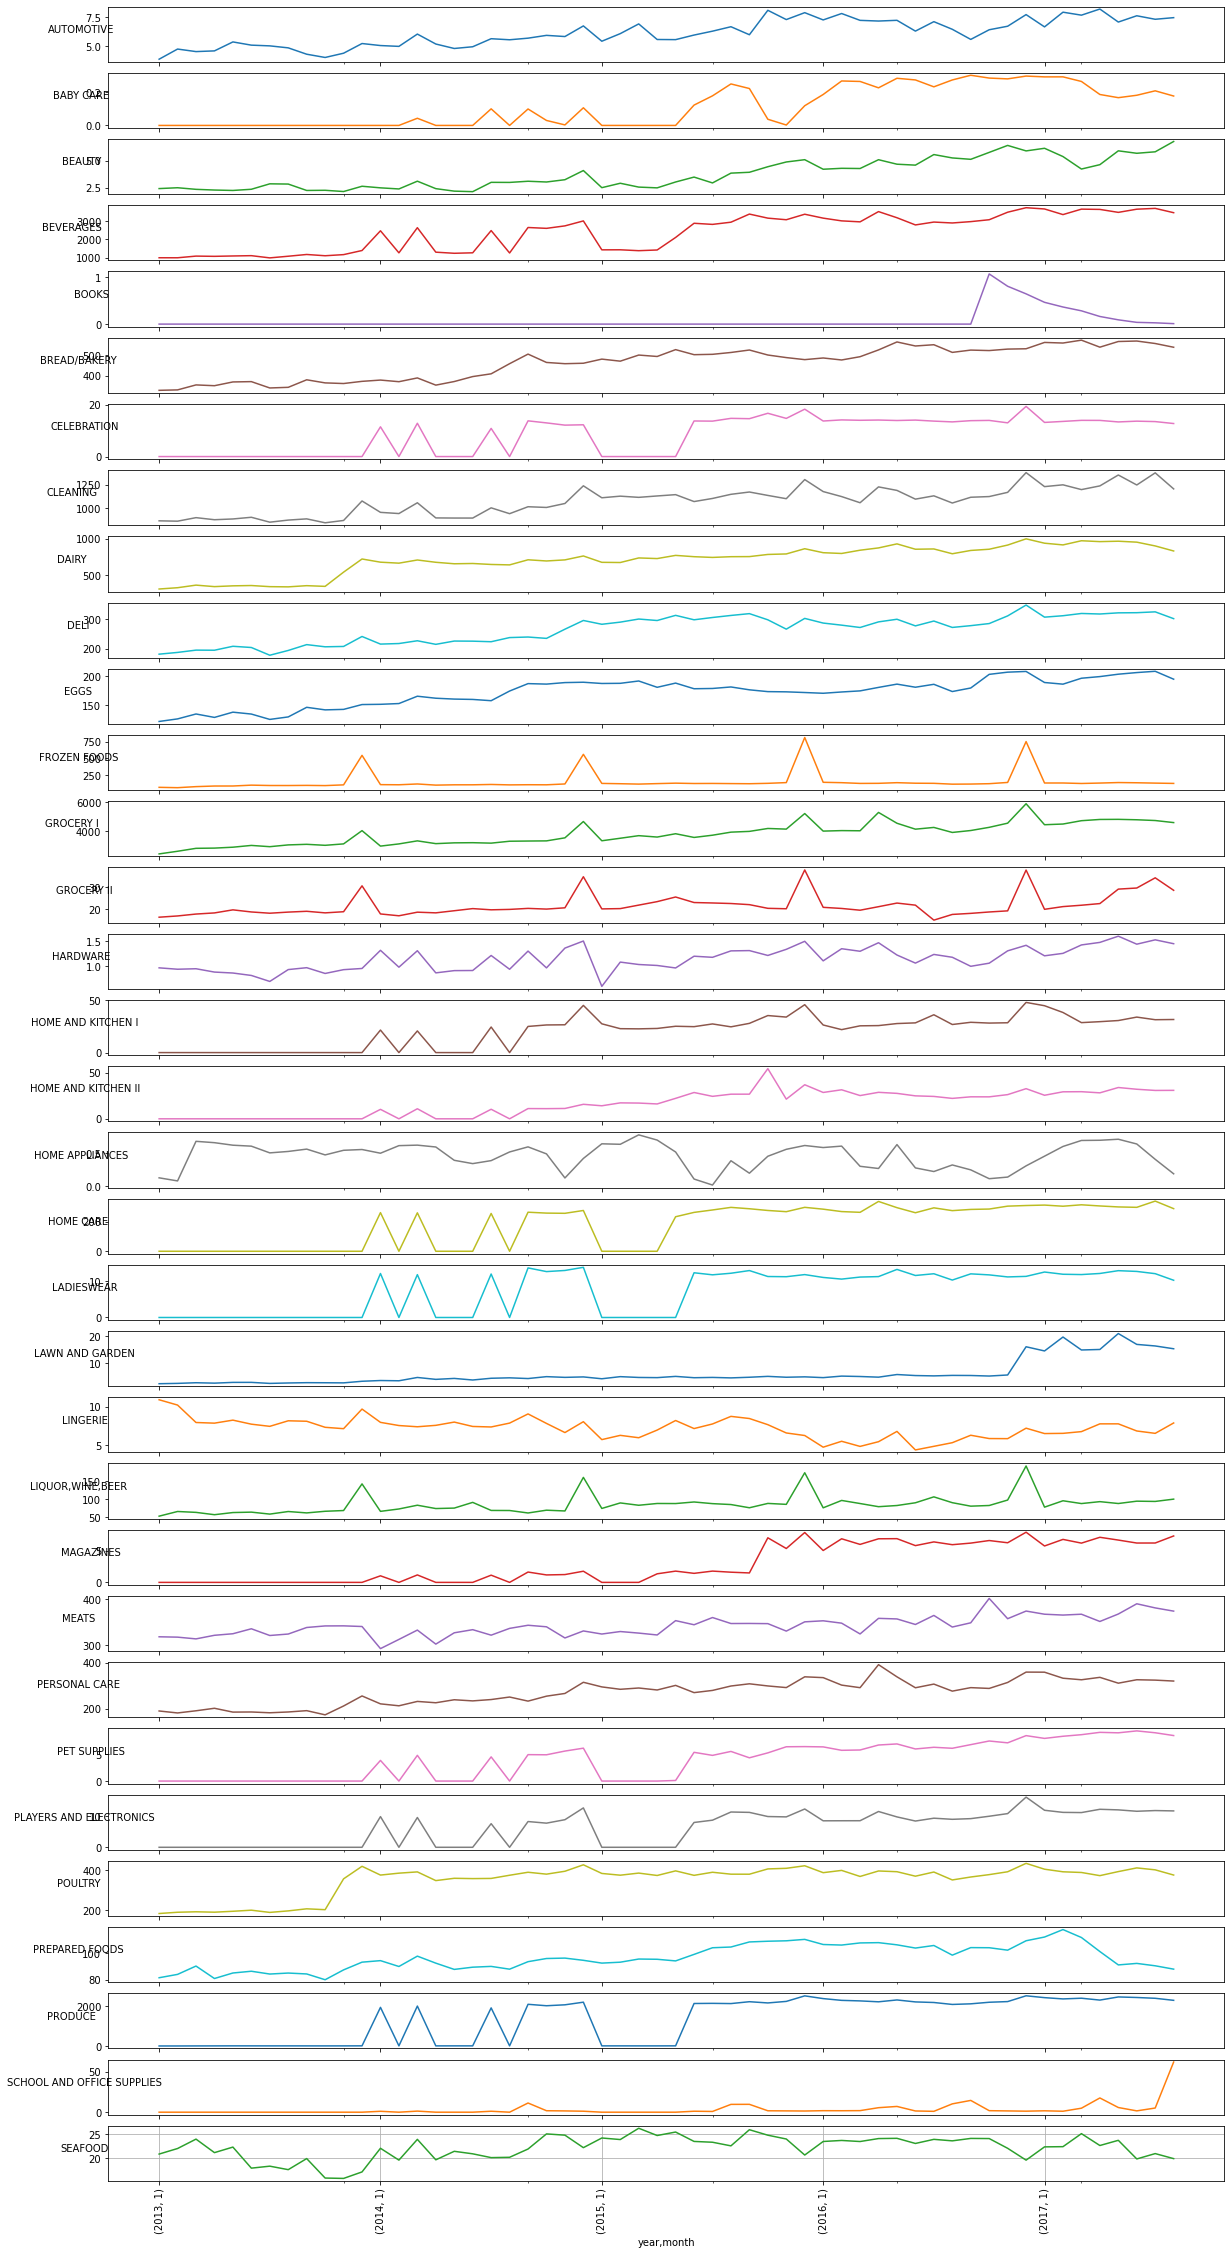

In [59]:
import warnings
warnings.simplefilter ('ignore') 
mhso_df['month'] = pd.to_datetime(mhso_df['date']).dt.month.values
mhso_df['year'] = pd.to_datetime(mhso_df['date']).dt.year.values
family_groups = mhso_df.groupby(['family'])['sales', 'month', 'year']
fam_sales = pd.DataFrame()
# ax.set_figheight(20)
# ax.set_figwidth(20)
i = 0
for fam, group in family_groups:
    fam_sales[fam] = group.groupby(['year', 'month']).mean()
axes = fam_sales.plot(subplots = True, legend = False, figsize = (20, 40))
for i in range(len(axes)):
    axes[i].set_ylabel(fam_sales.columns[i], rotation = 0)
plt.xticks(range(len(tmp.index))[::12], tmp.index[::12], rotation = 90)
plt.grid()
plt.show()

##### Correlation giữa sales của từng type với giá dầu

<AxesSubplot:>

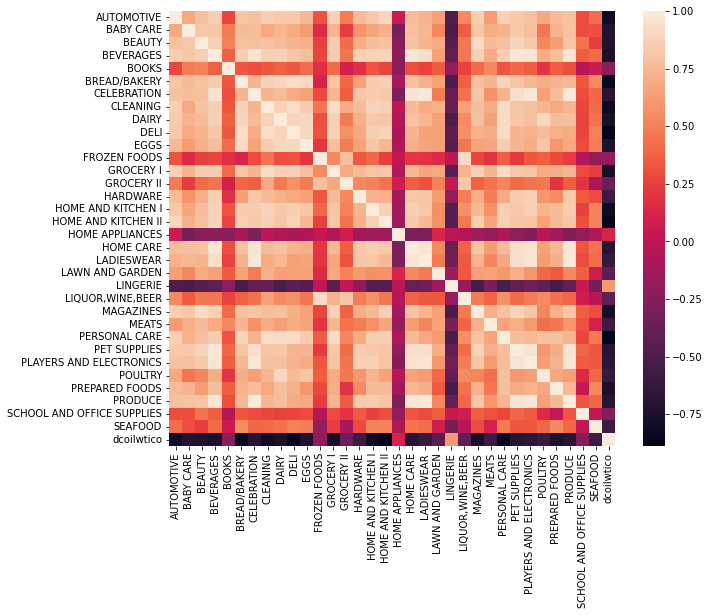

In [76]:
fam_sale_oil = pd.concat([fam_sales, tmp], axis = 1)
fam_sale_oil = fam_sale_oil.rename({'dcoilwtico': 'oil_price'})
plt.figure(figsize = (10, 8))
sns.heatmap(fam_sale_oil.corr())

##### Biến đổi giá dầu theo thời gian

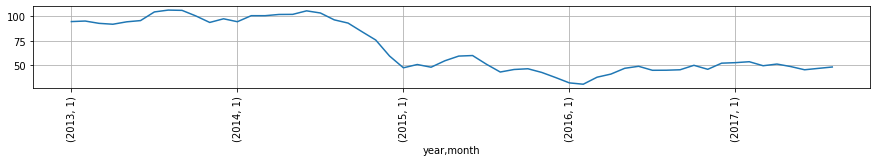

In [56]:
oil_df['month'] = pd.to_datetime(oil_df['date']).dt.month.values
oil_df['year'] = pd.to_datetime(oil_df['date']).dt.year.values
tmp = oil_df.groupby(['year', 'month'])['dcoilwtico'].mean()
ax = tmp.plot(figsize = (15, 1.5))
plt.xticks(range(len(tmp.index))[::12], tmp.index[::12], rotation = 90)
plt.grid()

In [22]:
mhsot_df = mhso_df.merge(transaction_df, how = 'left', left_on = ['date', 'store_nbr'], right_on = ['date', 'store_nbr'])
mhsot_df['month_day'] = pd.to_datetime(mhsot_df['date']).dt.day.values
mhsot_df.tail(2)

,date,store_nbr,family,sales,onpromotion,type_x,locale,locale_name,description,transferred,city,state,type_y,cluster,dcoilwtico,transactions,month_day
3054346,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.0,8,Holiday,Local,Riobamba,Fundacion de Riobamba,False,Quito,Pichincha,B,6,47.57,2155.0,15
3054347,2017-08-15,9,SEAFOOD,16.0,0,Holiday,Local,Riobamba,Fundacion de Riobamba,False,Quito,Pichincha,B,6,47.57,2155.0,15


In [27]:
from statsmodels.tsa.deterministic import DeterministicProcess, CalendarFourier
fourierA = CalendarFourier(freq='A', order=5)
fourierM = CalendarFourier(freq='M', order=2)
fourierW = CalendarFourier(freq='W', order=4)
# dp = DeterministicProcess(index=df.index,
#                           order=1,
#                           seasonal=False,
#                           constant=False,
#                           additional_terms=[fourierA, fourierM, fourierW],
#                           drop=True)



In [38]:
fourierA = CalendarFourier(freq='A', order=2)
x = fourierA.in_sample(pd.to_datetime(mhsot_df['date']))

<AxesSubplot:xlabel='date'>

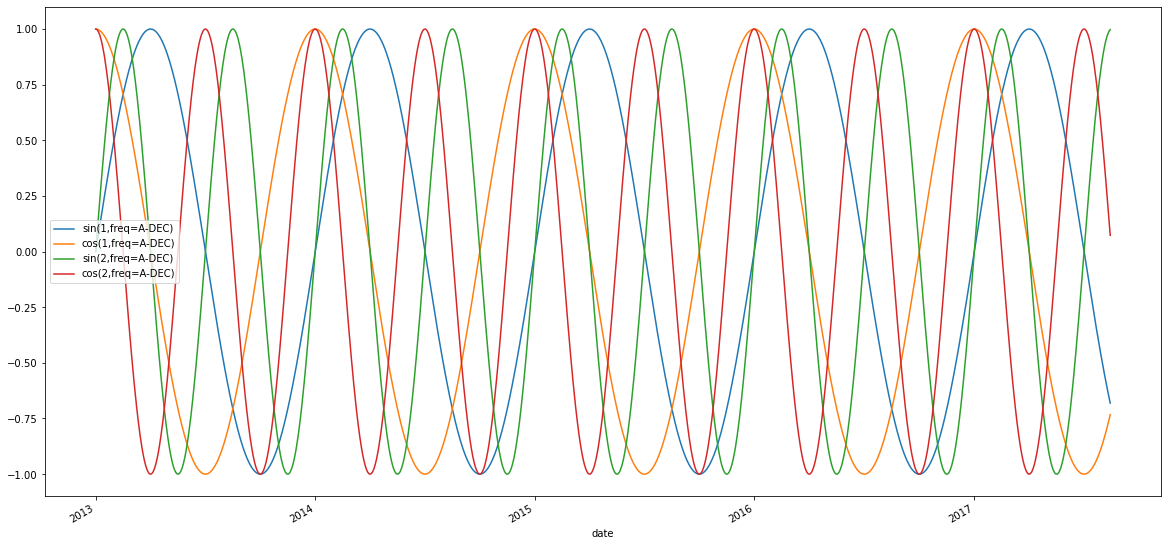

In [39]:
x.plot(figsize = (20, 10))

In [42]:
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
class FeatureEncoder2(object):
    """
        Thực hiện:
         - chuyển family, store_nbr -> one-hot
         - chuyển date -> tập one-hot của dayOfWeek & của month
         - normalize onPromotion
    """
    def __init__(self, X_df):
        self.family_encoder = OneHotEncoder().fit(X_df[['family']])
        self.store_nbr_encoder = OneHotEncoder().fit(X_df[['store_nbr']])
        weekday = pd.to_datetime(X_df['date']).dt.dayofweek.values.reshape(-1,1)
        self.week_encoder = OneHotEncoder().fit(weekday)
        month = pd.to_datetime(X_df['date']).dt.month.values.reshape(-1,1)
        self.month_encoder = OneHotEncoder().fit(month)
        self.scaler = MinMaxScaler().fit(X_df[['onpromotion']])
        self.holiday_type_encoder = OneHotEncoder().fit(X_df[['type']])
        
    def date2feature(self, date_col):
        weekday = pd.to_datetime(date_col).dt.dayofweek.values.reshape(-1,1)
        weekday_feature = self.week_encoder.transform(weekday).todense()
        month = pd.to_datetime(date_col).dt.month.values.reshape(-1,1)
        month_feature = self.month_encoder.transform(month).todense()
        return np.hstack([weekday_feature, month_feature])

    def preprocess(self, df):
        family_features = self.family_encoder.transform(df[['family']]).todense()
        store_nbr_features = self.store_nbr_encoder.transform(df[['store_nbr']]).todense()
        date_features = self.date2feature(df['date'])
        onProm_feature = self.scaler.transform(df[['onpromotion']])
        holiday_type_feature = self.holiday_type_encoder.transform(df[['type']]).todense()
        X1 = np.hstack([family_features, store_nbr_features, holiday_type_feature])
        X2 = np.hstack([date_features, onProm_feature])
        print(holiday_type_feature.shape)
        X = np.hstack([X1, X2])
        return X
    
merged_df = train_df.merge(holiday_df, how='left', left_on = 'date', right_on = 'date')
merged_df.loc[:, ['type']] = merged_df['type'].fillna("Not Holiday")
merged_df.loc[:, ['locale_name']] = merged_df['locale_name'].fillna("None")
encoder = FeatureEncoder2(merged_df)
X_train = encoder.preprocess(merged_df)
print(X_train.shape)

(3000888, 7)
(3000888, 114)


In [21]:
merged_df['type'].value_counts()

Not Holiday    3000888
Name: type, dtype: int64

In [13]:
X_train.shape

(2400710, 108)

In [43]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
y_train = merged_df['sales'].values
X_train2, X_val, y_train2, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = random_state)

# model = Ridge(alpha = 1)
model = RandomForestRegressor(n_estimators = 10)
model.fit(X_train2, y_train2)

C:\Users\thamnt36\Anaconda3\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


RandomForestRegressor(n_estimators=10)

In [44]:
y_pred = model.predict(np.asarray(X_val))
rmsle(y_val, y_pred)

1.2063155963460948

In [45]:
test_df = pd.read_csv('test.csv', index_col='id')
test_merged_df = test_df.merge(holiday_df, how='left', left_on = 'date', right_on = 'date')
test_merged_df.loc[:, ['type']] = test_merged_df['type'].fillna("Not Holiday")
test_merged_df.loc[:, ['locale_name']] = test_merged_df['locale_name'].fillna("None")
X_test= encoder.preprocess(test_merged_df)
y_pred = model.predict(X_test)
y_pred = np.where(y_pred > 0, y_pred, 0)
submit = pd.DataFrame(np.hstack([test_df.index.values.reshape(-1, 1), y_pred.reshape(-1, 1)]), columns = ['id', 'sales'])
submit.id = submit.id.astype(np.int32)
submit.to_csv('submit.csv', index=False)

(28512, 7)


C:\Users\thamnt36\Anaconda3\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


In [38]:
adf = holiday_df.iloc[40:50]
bdf = train_df.iloc[[1000, 2000, 1001]]
bdf.tail(3)

,id,date,store_nbr,family,sales,onpromotion
1000,1000,2013-01-01,37,EGGS,0.0,0
2000,2000,2013-01-02,15,LAWN AND GARDEN,0.0,0
1001,1001,2013-01-01,37,FROZEN FOODS,0.0,0


In [36]:
bdf.merge(adf, how='left', left_on = 'date', right_on = 'date')

,id,date,store_nbr,family,sales,onpromotion,type,locale,locale_name,description,transferred
0,1000,2013-01-01,37,EGGS,0.0,0,Holiday,National,Ecuador,Primer dia del ano,False
1,2000,2013-01-02,15,LAWN AND GARDEN,0.0,0,NaN,NaN,NaN,NaN,NaN


In [44]:
holiday_df.loc[holiday_df['date'].duplicated()].shape

(38, 6)

In [12]:
holiday_df.shape

(350, 6)